In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os 
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj

from pysteps.visualization import get_colormap

import pincast_verif.io_tools as io
from pincast_verif.nowcast_plot_tools import animate_image_sequence, plot_image_grid

In [3]:
def proj4_to_cartopy(proj4str):
    proj = pyproj.Proj(proj4str)

    km_proj = {"lon_0": "central_longitude",
               "lat_0": "central_latitude",
               "lat_ts": "true_scale_latitude",
               "x_0": "false_easting",
               "y_0": "false_northing",
               "k": "scale_factor",
               "zone": "zone"}
    km_globe = {'a': "semimajor_axis",
                'b': "semiminor_axis"}
    km_std = {"lat_1": "lat_1",
              "lat_2": "lat_2"}

    kw_proj  = {}
    kw_globe = {}
    kw_std   = {}

    for s in proj.srs.split('+'):
        s = s.split('=')
        if len(s) != 2:
            continue
        k = s[0].strip()
        v = s[1].strip()
        try:
            v = float(v)
        except:
            pass

        if k == "proj":
            if v == "tmerc":
                cl = ccrs.TransverseMercator
            elif v == "laea":
                cl = ccrs.LambertAzimuthalEqualArea
            elif v == "lcc":
                cl = ccrs.LambertConformal
            elif v == "merc":
                cl = ccrs.Mercator
            elif v == "utm":
                cl = ccrs.UTM
            elif v == "stere":
                cl = ccrs.Stereographic
            elif v == "aea":
                cl = ccrs.AlbersEqualArea
            elif v == "somerc":
                raise UnsupportedSomercProjection("unsupported projection: somerc")
            else:
                raise ValueError("unsupported projection: %s" % v)
        elif k in km_proj:
            kw_proj[km_proj[k]] = v
        elif k in km_globe:
            kw_globe[km_globe[k]] = v
        elif k in km_std:
            kw_std[km_std[k]] = v

    globe = None
    if kw_globe:
        globe = ccrs.Globe(**kw_globe)
    if kw_std:
        kw_proj["standard_parallels"] = (kw_std["lat_1"], kw_std["lat_2"])

    if cl.__name__ == "Mercator":
        kw_proj.pop("false_easting",  None)
        kw_proj.pop("false_northing", None)

    return cl(globe=globe, **kw_proj)

from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str, pos="top", x=-0.03, y=0.4, fontsize=10):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    if pos == "top":
        row.set_title(f'{title}\n', fontweight='semibold',x=x,y=y,fontsize=fontsize)
    elif pos == "left":
        row.set_title(f'{title}\n', fontweight='semibold',rotation="vertical",x=x,y=y,fontsize=fontsize)
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [4]:
DATA_FOLDER = Path("../data")
OUTPUT_FOLDER = DATA_FOLDER / "figures"

pred_path = os.path.join(DATA_FOLDER / "deuce_nowcasts" / "deuce-raw-2022-cases.hdf5")
obs_path = os.path.join(DATA_FOLDER / "baseline_nowcasts" / "measurements-2022-cases.hdf5")

ts = "2022-07-09 15:00:00"

observation_metadata = io.get_hdf5_metadata(obs_path)
prediction_metadata = io.get_hdf5_metadata(pred_path)

In [5]:
#projdef = "+proj=stere +lon_0=25.0 +lat_0=60.0 +lat_ts=60.0 +R=6370997.0 +x_0=320420.66239 +y_0=97694.4330307 +units=m"
projdef = "+proj=stere +a=6371288 +lon_0=25E +lat_0=90N +lat_ts=60 +x_0=380886.310 +y_0=3395677.920 +no_defs"

#ll_lon = 19.4
#ll_lat = 58.0
#ur_lon = 35.2
#ur_lat = 70.2


#popular bbox
ll_lon = 18.60
ll_lat = 57.93
ur_lon = 34.903
ur_lat = 69.005

proj = pyproj.Proj(projdef)
crs = proj4_to_cartopy(projdef)

cartopy_scale = "50m"

x0, y0 = proj(ll_lon, ll_lat)
x1, y1 = proj(ur_lon, ur_lat)
X = np.linspace(x0, x1, 760)[125:637]
Y = np.linspace(y0, y1, 1226)[110:622]
x0,x1,y0,y1 = X[0],X[-1],Y[0],Y[-1]

In [6]:
prediction_metadata["leadtimes"]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [7]:
prediction = io.load_data(
            db_path=pred_path,
            data_location_getter=io.get_prediction_data_locs,
            time_0=ts,
            leadtimes=prediction_metadata["leadtimes"],
            method_name=prediction_metadata["method_name"]
)
prediction[...,1] = prediction[...,1] + 32.0

observation = io.load_data(
            db_path=obs_path,
            data_location_getter=io.get_observation_data_locs,
            time_0=ts,
            leadtimes=prediction_metadata["leadtimes"],
            method_name=observation_metadata["method_name"]
        )

In [8]:
pred_mean = prediction[...,0].mean(axis=1)
pred_al = (prediction[...,1]).mean(axis=1)
pred_ep = prediction[...,0].std(axis=1)

In [9]:
rand_eps = np.random.normal(size=48)
pred_var = ((prediction[...,1]**2).mean(axis=1)) + prediction[...,0].var(axis=1)
pred_std = np.sqrt(pred_var)
pred_combined = np.stack([pred_mean + e * np.sqrt(pred_var) for e in rand_eps])

In [20]:
al_perc = (pred_al**2 / pred_var) * 100
ep_perc = (pred_ep**2 / pred_var) * 100

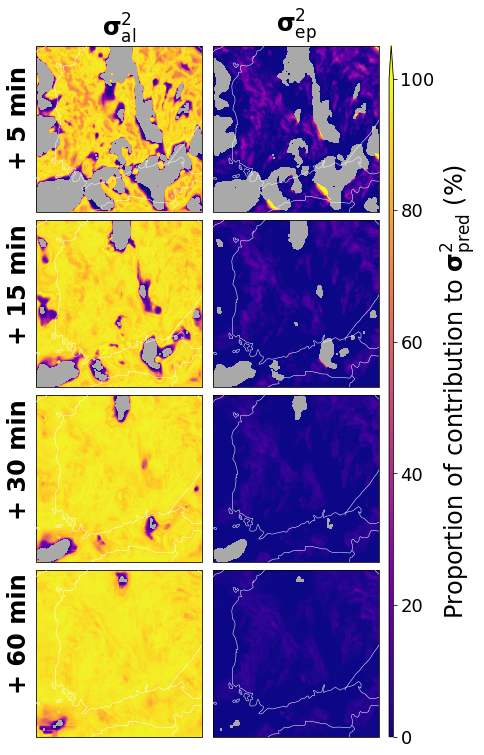

In [26]:
n_stds = 1
fs = 24 #24
fs_tick = 18 #18
cmap, norm, clevs, clevs_str = get_colormap("intensity",units="dBZ")
cmap_sigma = matplotlib.cm.plasma
cmap_sigma.set_bad('darkgray',1.)
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(2*3,4*3), subplot_kw={"projection" : crs})

ax[0,0].set_title("$\mathbf{\sigma}^2_{\mathrm{al}}$", fontsize=fs, fontweight="semibold")
ax[0,1].set_title("$\mathbf{\sigma}^2_{\mathrm{ep}}$", fontsize=fs, fontweight="semibold")

ax[0,0].set_ylabel("+ 5 min")
ax[1,0].set_ylabel("+ 15 min")
ax[2,0].set_ylabel("+ 30 min")
ax[3,0].set_ylabel("+ 60 min")

for i,lt in enumerate([0,2,5,11]):

    for j in range(2):
        ax[i,j].set_extent((x0, x1, y0, y1), crs)
        if j in [0,1]:
            edgecolor = "white"
        else:
            edgecolor = "black"
        ax[i,j].add_feature(cfeature.NaturalEarthFeature("physical", "coastline", scale=cartopy_scale,
                edgecolor=edgecolor, facecolor="none", linewidth=0.5), zorder=100)
        ax[i,j].add_feature(cfeature.NaturalEarthFeature("cultural", "admin_0_boundary_lines_land",
                scale=cartopy_scale, edgecolor=edgecolor, facecolor="none", linewidth=0.5),
                zorder=100)

    im_sigma = ax[i,0].imshow(al_perc[lt],extent=(x0, x1, y0, y1), cmap=cmap_sigma, vmin=0, vmax=100)
    ax[i,1].imshow(ep_perc[lt],extent=(x0, x1, y0, y1), cmap=cmap_sigma, vmin=0, vmax=100)
    
ax[0,0].set_ylabel("+ 5 min", fontsize=fs)
#
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    wspace=0.05,
    hspace=0.05)
    
cbar_sigma_ax = fig.add_axes([0.92, 0.1, 0.01, 0.8])

cbar_sigma = plt.colorbar(
    im_y, ticks=clevs, spacing="uniform", extend="max", pad=0.2, cax=cbar_y_ax
)

#if clevs_str is not None:
#    cbar_y_ax.set_yticklabels(clevs_str)
#    cbar_y_ax.tick_params(labelsize=fs_tick)
#cbar_y.ax.set_title("dBZ", fontsize=14)
#cbar_y.set_label(f"Proportion", fontsize=fs)
#cbar_y.ax.yaxis.set_label_position('left')


cbar_sigma = fig.colorbar(im_sigma, spacing="uniform", extend="max",cax=cbar_sigma_ax)
cbar_sigma.set_label("Proportion of contribution to $\mathbf{\sigma}^2_{\mathrm{pred}}$ (%)", fontsize=fs)
cbar_sigma_ax.tick_params(labelsize=fs_tick)


# leadtime labels
grid = plt.GridSpec(4, 5)
time_x = -0.005
time_y = 0.25
create_subtitle(fig, grid[0,::], '+ 5 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[1,::], '+ 15 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[2,::], '+ 30 min', pos="left", x=time_x, y=time_y, fontsize=fs)
create_subtitle(fig, grid[3,::], '+ 60 min', pos="left", x=time_x, y=time_y, fontsize=fs)

fig.tight_layout()
fig.savefig(OUTPUT_FOLDER / "rev2_perc_uncertainty.png", bbox_inches='tight')
fig.show()